# HX Cooling Performance — Combined Analysis (2025-10-21 & 2025-10-23 & 2025-10-24)

Analysis of the no-mix baseline, mixed bath, and mixed bath with automatic LN control, using a common ambient heat leak derived from the warm-up log. Sensors: U1 bottom, U2 coil top, U3 bath top, U4 coil middle. The submerged heat-exchanger area in the antifreeze bath is 0.12 m².


## Paths, constants, helper imports


In [45]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import hfe_ana
import hfe_ana.notebook as hfe_notebook
importlib.reload(hfe_notebook)
importlib.reload(hfe_ana)


from hfe_ana import (
    apply_corrections,
    bath_capacity_j_per_k,
    fit_heat_leak_linear,
    fit_ua_from_corrected,
    fit_temperature_window,
    heat_leak_subset,
    integrate_corrected_power,
    plot_heat_leak_fit,
    plot_power_and_flux,
    plot_temperature_window_fit,
    plot_temperatures,
    predict_heat_leak_fit,
    prepare_dataset,
    summarize_windows,
    WindowTemperatureFit,
)

NB_PATH = Path.cwd()
REPO_ROOT = NB_PATH
for candidate in [NB_PATH, *NB_PATH.parents]:
    if (candidate / 'data').exists() and (candidate / 'analysis').exists():
        REPO_ROOT = candidate
        break

RAW_DIR = REPO_ROOT / 'data' / 'raw'
NOMIX_CSV = RAW_DIR / 'tc_log_20251021_152400-nomix.csv'
MIXED_CSV = RAW_DIR / 'tc_log_20251023_140530-mixed.csv'
MIXED_60PSI_CSV = RAW_DIR / 'tc_log_20251024_142037_mixed60psi.csv'
AUTO_CSV = RAW_DIR / 'tc_log_20251023_142833-mixed_auto.csv'
WARMUP_CSV = RAW_DIR / 'tc_log_20251023_154857-warmup2.csv'

PROCESSED_DIR = REPO_ROOT / 'data' / 'processed'
REPORTS_DIR = REPO_ROOT / 'data' / 'reports'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

ROLL_WINDOW_S = 45.0
WARMUP_TMIN_MIN = 20.0
EARLY_TMIN0 = 1.0
EARLY_TMIN1 = 5.0
EARLY_DT_MIN = 2.0
EARLY_DT_MAX = 12.0
SUMMARY_WINDOWS = [(2, 6), (6, 10), (10, 14)]
ENERGY_WINDOW = (2.0, 12.0)
HX_AREA_M2 = 0.12

COIL_MID_WEIGHT = 0.75
COIL_TOP_WEIGHT = 0.25

def apply_weighted_coil_temperature(df: pd.DataFrame) -> pd.DataFrame:
    """Recompute coil mean (75% mid, 25% top) and refresh DeltaT."""
    if {"U4_coilMid_C", "U2_coilTop_C"}.issubset(df.columns):
        df["T_coil_mean_C"] = (
            COIL_MID_WEIGHT * df["U4_coilMid_C"] + COIL_TOP_WEIGHT * df["U2_coilTop_C"]
        )
    if {"T_bulk_mean_C", "T_coil_mean_C"}.issubset(df.columns):
        df["DeltaT_C"] = df["T_bulk_mean_C"] - df["T_coil_mean_C"]
    return df

GLYCOL_MASS_FRAC = 0.76
CP_GLYCOL_KJ_PER_KG_K = 2.42
CP_WATER_KJ_PER_KG_K = 4.18
RHO_GLYCOL_KG_PER_L = 1.113
RHO_WATER_KG_PER_L = 0.998
FILL_VOLUME_L = 5.65
FILL_VOLUME_NOMIX_L = 5.40

cp_kJkgK = GLYCOL_MASS_FRAC * CP_GLYCOL_KJ_PER_KG_K + (1 - GLYCOL_MASS_FRAC) * CP_WATER_KJ_PER_KG_K
rho_kgL = GLYCOL_MASS_FRAC * RHO_GLYCOL_KG_PER_L + (1 - GLYCOL_MASS_FRAC) * RHO_WATER_KG_PER_L
Cp_nomix_JK = bath_capacity_j_per_k(FILL_VOLUME_NOMIX_L, rho_kgL, cp_kJkgK)
Cp_JK = bath_capacity_j_per_k(FILL_VOLUME_L, rho_kgL, cp_kJkgK)
bath_mass_kg = FILL_VOLUME_L * rho_kgL
bath_mass_nomix_kg = FILL_VOLUME_NOMIX_L * rho_kgL
print(f'Bath Cp (5.65 L) = {Cp_JK:,.0f} J/K; nomix Cp (5.40 L) = {Cp_nomix_JK:,.0f} J/K; mixture cp = {cp_kJkgK:.3f} kJ/kg-K; bath mass = {bath_mass_kg:.2f} kg (nomix {bath_mass_nomix_kg:.2f} kg)')

PSI_TO_PA = 6894.75729

LN_TUBING_ID_M = 3.87e-3  # 3.87 mm inner diameter
LN_TUBING_AREA_M2 = np.pi * (LN_TUBING_ID_M / 2.0) ** 2
LN_LIQUID_DENSITY_KG_M3 = 807.0  # liquid nitrogen at ~77 K

LN_FLOW_SCENARIOS = [
    {
        'key': 'baseline_25psi',
        'label': 'Baseline 25 psi (Oct 21 & 23 runs)',
        'pressure_psi': 25.0,
        'notes': 'Nominal manual-mix operation used for earlier datasets.',
    },
    {
        'key': 'mixed_60psi',
        'label': '60 psi mixed run (Oct 24)',
        'pressure_psi': 60.0,
        'notes': 'Measured 25 m/s gaseous nitrogen at HX outlet; assumes same 3.87 mm ID for quick volumetric estimate.',
        'measured_outlet_velocity_ms': 25.0,
    },
]

flow_rows = []
for scenario in LN_FLOW_SCENARIOS:
    pressure_pa = scenario['pressure_psi'] * PSI_TO_PA
    ideal_exit_velocity_ms = np.sqrt(2.0 * pressure_pa / LN_LIQUID_DENSITY_KG_M3)
    velocity_used_ms = scenario.get('measured_outlet_velocity_ms', ideal_exit_velocity_ms)
    velocity_source = 'measured' if 'measured_outlet_velocity_ms' in scenario else 'ideal'

    mass_flow = LN_LIQUID_DENSITY_KG_M3 * LN_TUBING_AREA_M2 * velocity_used_ms
    vol_flow_ml_s = mass_flow / LN_LIQUID_DENSITY_KG_M3 * 1e6

    row = {
        'scenario': scenario['label'],
        'gauge_pressure_psi': scenario['pressure_psi'],
        'velocity_used_ms': velocity_used_ms,
        'velocity_source': velocity_source,
        'ideal_exit_velocity_ms': ideal_exit_velocity_ms,
        'LN_mass_flow_g_s': mass_flow * 1e3,
        'LN_vol_flow_mL_s': vol_flow_ml_s,
        'notes': scenario.get('notes', ''),
    }

    measured = scenario.get('measured_outlet_velocity_ms')
    if measured is not None:
        row['measured_outlet_velocity_ms'] = measured
        row['measured_gas_vol_flow_L_min'] = measured * LN_TUBING_AREA_M2 * 60.0 * 1e3
    flow_rows.append(row)

ln_flow_df = pd.DataFrame(flow_rows)
ln_flow_df

Bath Cp (5.65 L) = 17,431 J/K; nomix Cp (5.40 L) = 16,660 J/K; mixture cp = 2.842 kJ/kg-K; bath mass = 6.13 kg (nomix 5.86 kg)


,scenario,gauge_pressure_psi,velocity_used_ms,velocity_source,ideal_exit_velocity_ms,LN_mass_flow_g_s,LN_vol_flow_mL_s,notes,measured_outlet_velocity_ms,measured_gas_vol_flow_L_min
0,Baseline 25 psi (Oct 21 & 23 runs),25.0,20.668441,ideal,20.668441,196.197321,243.119356,Nominal manual-mix operation used for earlier ...,NaN,NaN
1,60 psi mixed run (Oct 24),60.0,25.000000,measured,32.019412,237.315090,294.070744,Measured 25 m/s gaseous nitrogen at HX outlet;...,25.0,17.644245


### Liquid-nitrogen mass-flow estimate

We approximate the transfer line as an inviscid nozzle that discharges liquid nitrogen to atmosphere. Using a 3.87 mm inner-diameter tube ($A=\pi d^2/4$) and $\rho=807\,\text{kg/m}^3$ at 77 K, Bernoulli’s equation gives the ideal exit speed $v = \sqrt{2\Delta P/\rho}$ and mass flow $\dot{m}=\rho A v$. When a measured outlet velocity is available (e.g. 25 m/s for the 60 psi run) we adopt it for the flow calculations, treating the ideal value as a reference. The table below compares the 25 psi baseline configuration with the 60 psi mixed run recorded on 2025-10-24.

## Ambient heat leak determination

During the warm-up segment the bath is isolated from active control, so the only driver is the quasi-steady ambient heat leak $\dot{Q}_{\text{amb}}$. For a bath with effective heat capacity $C_p$, the lumped energy balance is

$$
C_p \frac{dT}{dt} = \dot{Q}_{\text{amb}}.
$$

Assuming $\dot{Q}_{\text{amb}}$ is approximately constant over this interval and the fluid remains well mixed (conditions that hold after 20 minutes), the solution is linear in time:

$$
T(t) = T_0 + \frac{\dot{Q}_{\text{amb}}}{C_p}\, t.
$$

We therefore fit a straight line to the bulk-mean temperature for times $t \ge 20$ min while the valve is closed. The regression slope $dT/dt$ (in °C/s) multiplied by the bath heat capacity $C_p$ gives the ambient heat leak in watts, and the intercept captures the starting temperature. Excluding the pre-20-minute data removes transient mixing curvature so the linear model remains valid.


,time_s,temp0_C,U1_bottom_C,U2_coilTop_C,U3_top_C,U4_coilMid_C,temp5_C,temp6_C,temp7_C,temp8_C,...,t_min,T_bulk_mean_C,T_coil_mean_C,DeltaT_C,Strat_top_minus_bottom_C,time_s_raw,valve_state,dataset,dTbulk_dt_C_per_s,P_bath_W
0,0.000,NaN,-9.51,-15.49,-8.33,-10.83,NaN,NaN,NaN,NaN,...,0.00000,-8.920,-11.9950,3.0750,1.18,7722.399,0,warmup,0.001254,-21.852452
1,1.005,NaN,-9.48,-15.52,-8.34,-10.84,NaN,NaN,NaN,NaN,...,0.01675,-8.910,-12.0100,3.1000,1.14,7723.404,0,warmup,0.001237,-21.567786
2,2.010,NaN,-9.55,-15.51,-8.28,-10.84,NaN,NaN,NaN,NaN,...,0.03350,-8.915,-12.0075,3.0925,1.27,7724.409,0,warmup,0.001581,-27.551496


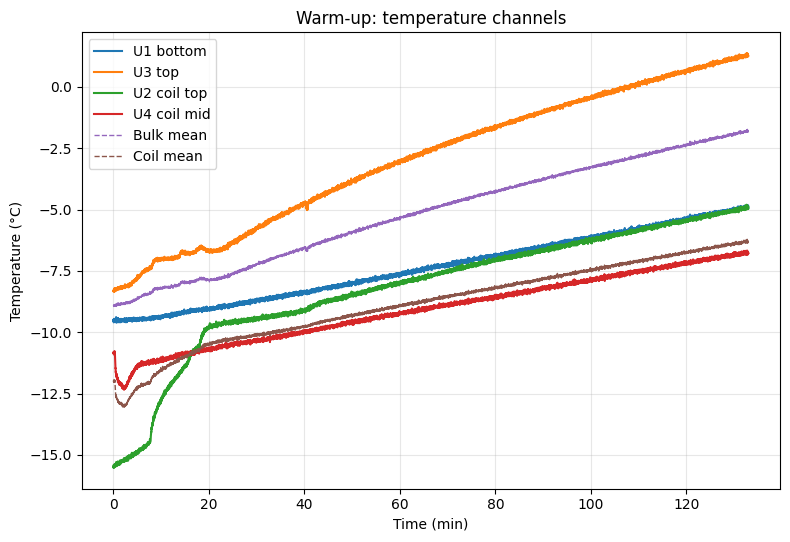

In [46]:
# 1) Inspect warm-up data and temperature channels
warmup_df, warmup_start = prepare_dataset(WARMUP_CSV, Cp_JK, label='warmup', window_s=ROLL_WINDOW_S)
apply_weighted_coil_temperature(warmup_df)
display(warmup_df.head(3))
fig, ax = plot_temperatures(
    warmup_df,
    title='Warm-up: temperature channels',
    include_valve=False,
    height_scale=1.2,
)


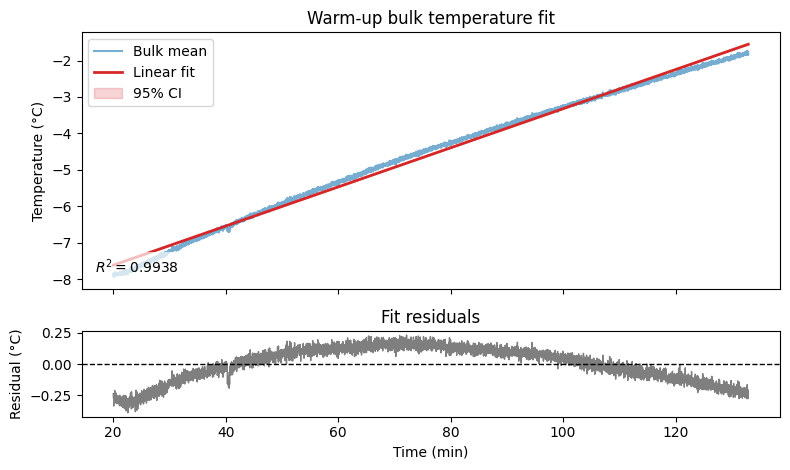

In [47]:
# 2) Fit the bulk mean temperature (t ≥ 20 min) and show residuals
warmup_subset = heat_leak_subset(warmup_df, tmin_start_min=WARMUP_TMIN_MIN, require_valve_closed=True)
fit_result = fit_heat_leak_linear(
    warmup_df,
    Cp_JK,
    tmin_start_min=WARMUP_TMIN_MIN,
    require_valve_closed=True,
)
predicted_C, lower_C, upper_C, se_C = predict_heat_leak_fit(fit_result, warmup_subset['time_s'])
fig_fit, ax_fit, ax_res = plot_heat_leak_fit(
    warmup_subset['t_min'],
    warmup_subset['T_bulk_mean_C'],
    predicted_C,
    band_lower_C=lower_C,
    band_upper_C=upper_C,
    residuals_C=warmup_subset['T_bulk_mean_C'] - predicted_C,
)


In [48]:
# 3) Heat leak summary
print(f'Warm-up samples used: {fit_result.n_samples}')
print(f'Ambient heat leak: {fit_result.heat_leak_W:.2f} W')
print(f'1σ uncertainty: {fit_result.heat_leak_sigma_W:.2f} W')
print(f'95% confidence interval: {fit_result.ci95_low_W:.2f} – {fit_result.ci95_high_W:.2f} W')
HEAT_LEAK_W = fit_result.heat_leak_W


Warm-up samples used: 6743
Ambient heat leak: 15.58 W
1σ uncertainty: 0.01 W
95% confidence interval: 15.56 – 15.61 W


## HX performance

For each dataset we assess the heat exchanger (HX) dynamics by plotting the corrected bath power and derived fluxes. The apparent bath power $P_{\text{bath}}$ comes from the rolling slope of the bulk mean temperature: using the bath heat capacity $C_p$, we compute

$$
P_{\text{bath}} = -C_p \, \frac{dT_{\text{bulk}}}{dt},
$$

where the negative sign reflects that a warming bath implies heat input. The corrected HX power removes the ambient leak so the curves represent only LN cooling:

$$
P_{\text{HX}} = P_{\text{bath}} + \dot{Q}_{\text{amb}},
$$

with $\dot{Q}_{\text{amb}}$ determined by the warm-up fit. The power panel in `plot_power_and_flux` shows both $P_{\text{HX}}$ and the corresponding conductance $UA$ obtained from the steady HX relation

$$
UA = \frac{P_{\text{HX}}}{\Delta T}, \qquad \Delta T = T_{\text{bulk mean}} - T_{\text{coil mean}}.
$$

To compare operating modes independent of hardware size we also compute the surface-normalised heat flux

$$
q'' = \frac{P_{\text{HX}}}{A_{\text{HX}}},
$$

and the per-area conductance $UA/A_{\text{HX}}$. These quantities populate the second subplot. Together the traces reveal how each run ramps power, whether a steady $\Delta T$ is maintained, and how the HX surface is utilised.



In [49]:
DATASETS = {
    'nomix': {
        'path': NOMIX_CSV,
        'title': 'No-mix baseline',
        'include_valve': False,
        'Cp_JK': Cp_nomix_JK,
    },
    'mixed': {
        'path': MIXED_CSV,
        'title': 'Mixed bath',
        'include_valve': False,
        'gauge_pressure_psi': 25.0,
    },
    'mixed_60psi': {
        'path': MIXED_60PSI_CSV,
        'title': 'Mixed bath — 60 psi LN (25 m/s outlet gas)',
        'include_valve': False,
        'gauge_pressure_psi': 60.0,
        'gas_velocity_ms': 25.0,
        'notes': 'Manual mixing with higher dewar pressure and measured outlet velocity.',
    },
    'auto': {
        'path': AUTO_CSV,
        'title': 'Automatic valve',
        'include_valve': True,
    },
}


datasets: dict[str, pd.DataFrame] = {}
for key, meta in DATASETS.items():
    cp_for_dataset = meta.get('Cp_JK', Cp_JK)
    df, start_time = prepare_dataset(meta['path'], cp_for_dataset, label=key, window_s=ROLL_WINDOW_S)
    apply_weighted_coil_temperature(df)
    corrected = apply_corrections(df, HEAT_LEAK_W)
    apply_weighted_coil_temperature(corrected)
    corrected['P_HX_W_m2'] = corrected['P_HX_W'] / HX_AREA_M2
    corrected['UA_per_area_W_per_m2K'] = corrected['UA_corr_W_per_K'] / HX_AREA_M2
    datasets[key] = corrected
    duration = corrected['t_min'].iloc[-1]
    print(f"Loaded {key}: start={start_time:.1f}s, duration={duration:.2f} min")
print(f'Ambient heat leak applied: {HEAT_LEAK_W:.2f} W')


Loaded nomix: start=12.1s, duration=15.11 min
Loaded mixed: start=1525.6s, duration=21.96 min
Loaded mixed_60psi: start=974.6s, duration=10.53 min
Loaded auto: start=2906.5s, duration=12.38 min
Ambient heat leak applied: 15.58 W


### 60 psi mixed run (2025-10-24)

- CSV: `data/raw/tc_log_20251024_142037_mixed60psi.csv`
- Manual mixing with the LN dewar regulator set to 60 psi.
- Inline measurement observed ≈25 m/s gaseous nitrogen at the HX outlet (≈17.6 L/min assuming the 3.87 mm transfer-line area).

In [50]:
meta_rows = []
for key, meta in DATASETS.items():
    df = datasets[key]
    duration_min = float(df['t_min'].iloc[-1]) if not df.empty else float('nan')
    row = {
        'dataset': key,
        'title': meta['title'],
        'duration_min': duration_min,
        'gauge_pressure_psi': meta.get('gauge_pressure_psi'),
        'gas_velocity_ms': meta.get('gas_velocity_ms'),
        'notes': meta.get('notes', ''),
    }
    meta_rows.append(row)

pd.DataFrame(meta_rows)


,dataset,title,duration_min,gauge_pressure_psi,gas_velocity_ms,notes
0,nomix,No-mix baseline,15.107500,NaN,NaN,
1,mixed,Mixed bath,21.958833,25.0,NaN,
2,mixed_60psi,Mixed bath — 60 psi LN (25 m/s outlet gas),10.532717,60.0,25.0,Manual mixing with higher dewar pressure and m...
3,auto,Automatic valve,12.377633,NaN,NaN,


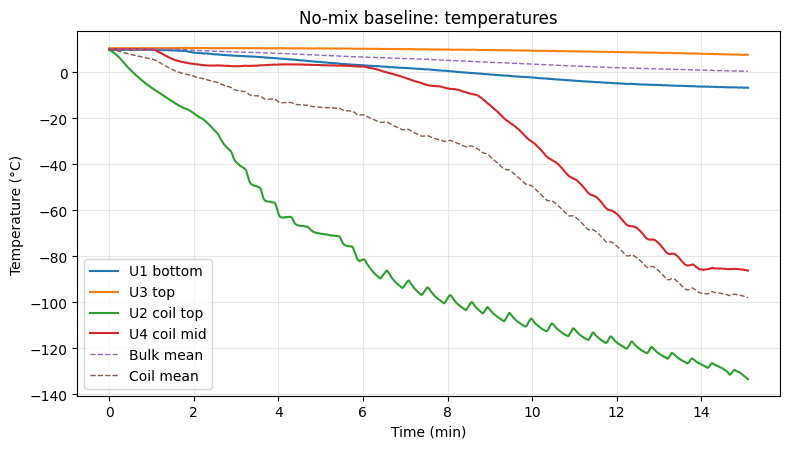

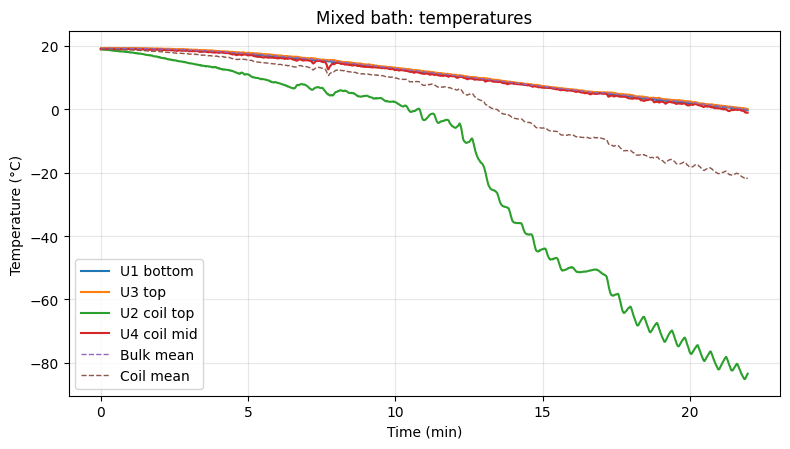

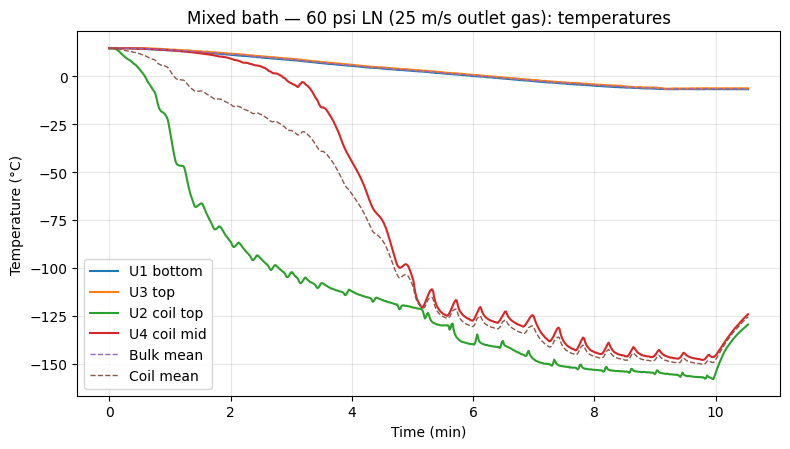

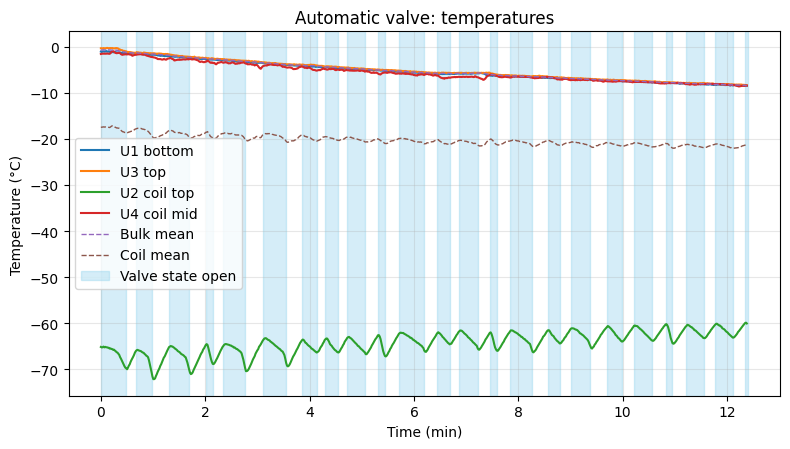

In [51]:
for key, meta in DATASETS.items():
    fig, _ = plot_temperatures(
        datasets[key],
        title=f"{meta['title']}: temperatures",
        include_valve=meta.get('include_valve', False),
    )
    fig


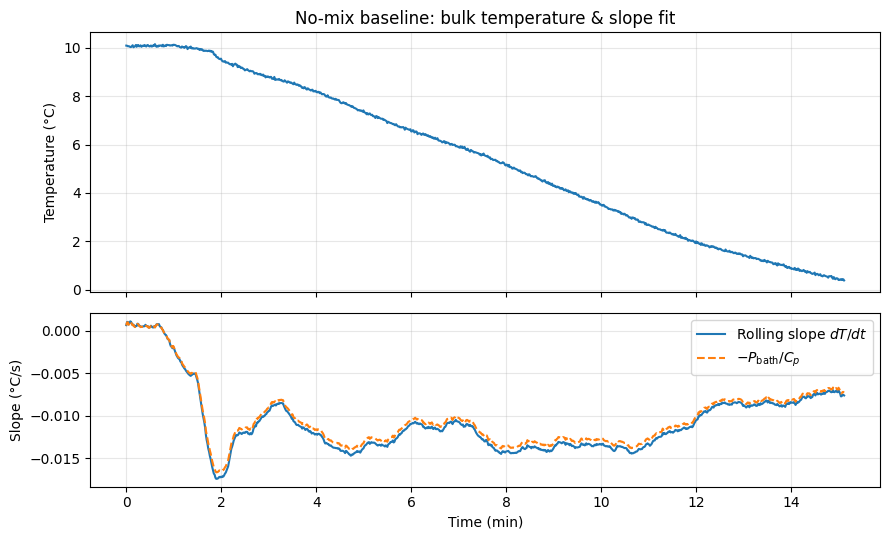

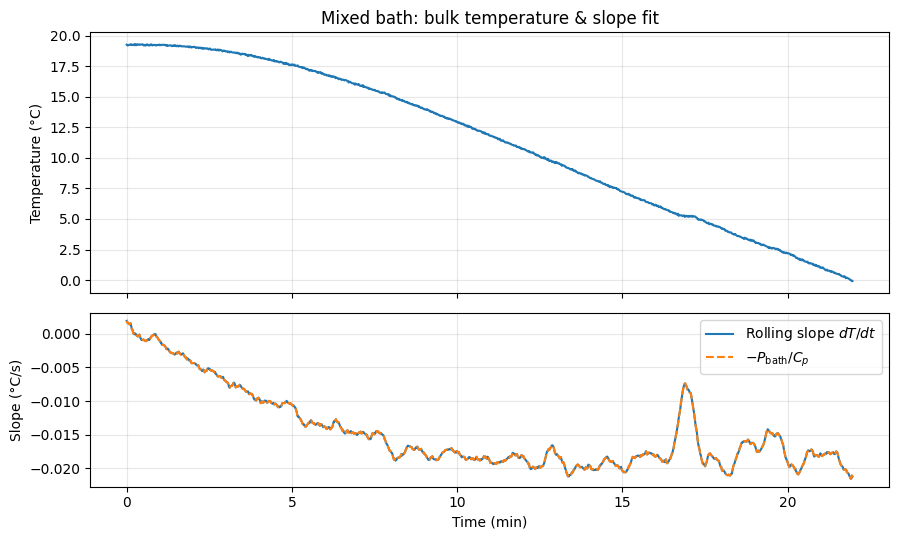

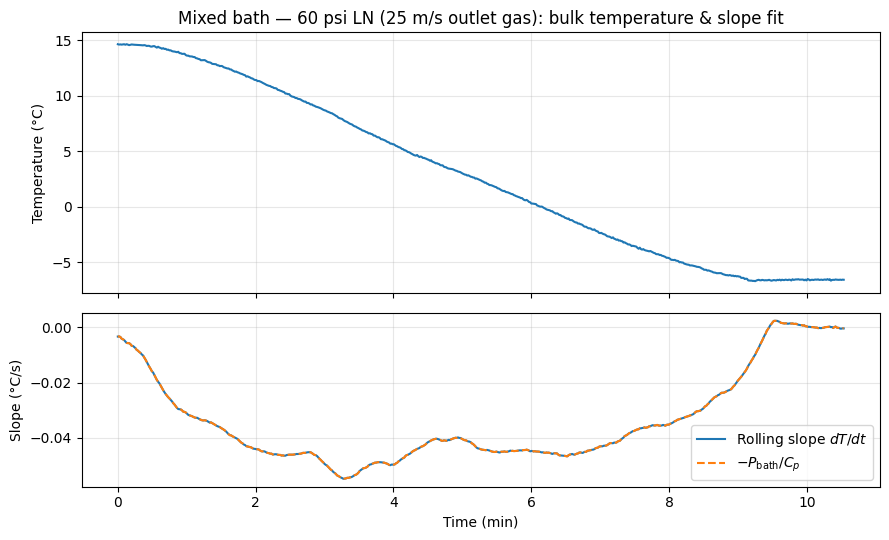

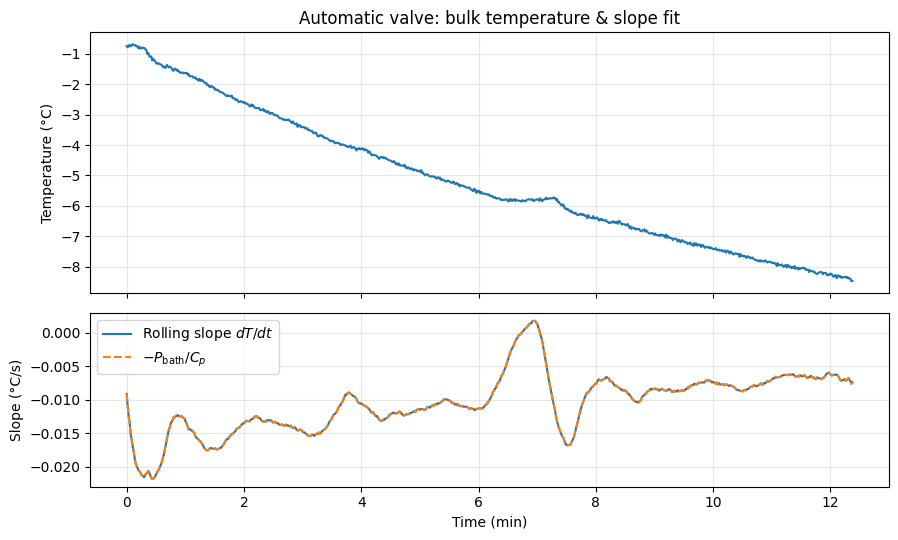

In [52]:
for key, meta in DATASETS.items():
    df = datasets[key]
    if df.empty or 'T_bulk_mean_C' not in df.columns:
        continue
    t_min = df['t_min']
    fig, axes = plt.subplots(2, 1, figsize=(9, 5.5), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

    axes[0].plot(t_min, df['T_bulk_mean_C'], label='Bulk mean')
    axes[0].set_ylabel('Temperature (°C)')
    axes[0].set_title(f"{meta['title']}: bulk temperature & slope fit")
    axes[0].grid(True, alpha=0.3)

    if 'dTbulk_dt_C_per_s' in df.columns and 'P_bath_W' in df.columns:
        slope_vals = df['dTbulk_dt_C_per_s']
        derived_slope = -df['P_bath_W'] / Cp_JK
        axes[1].plot(t_min, slope_vals, label=r"Rolling slope $dT/dt$")
        axes[1].plot(t_min, derived_slope, linestyle='--', label=r"$-P_{\mathrm{bath}}/C_p$")
        axes[1].set_ylabel('Slope (°C/s)')
        axes[1].legend(loc='best')
    else:
        axes[1].text(0.5, 0.5, 'Slope columns unavailable', ha='center', va='center')
        axes[1].set_ylabel('Slope (°C/s)')
    axes[1].set_xlabel('Time (min)')
    axes[1].grid(True, alpha=0.3)

    fig.tight_layout()
    plt.show()



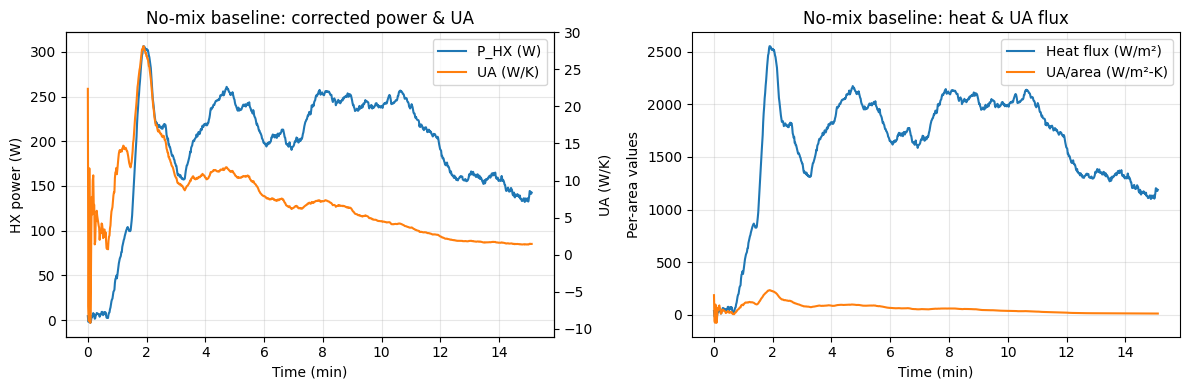

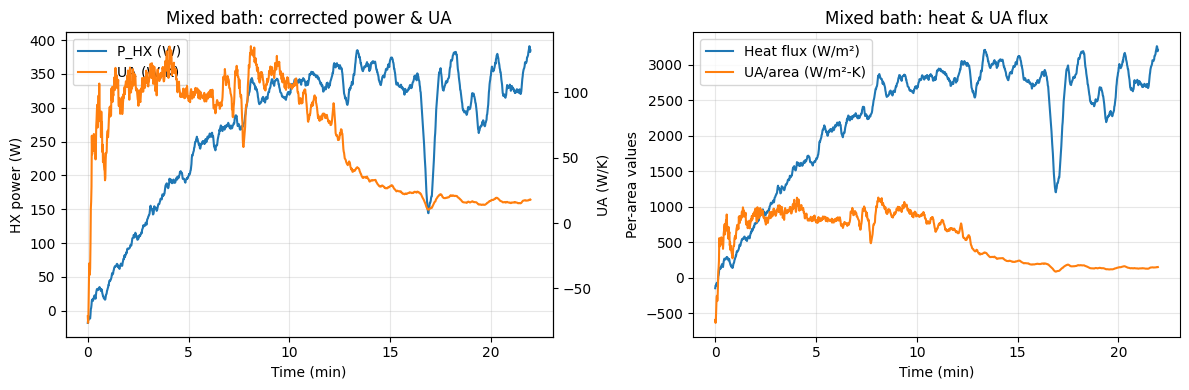

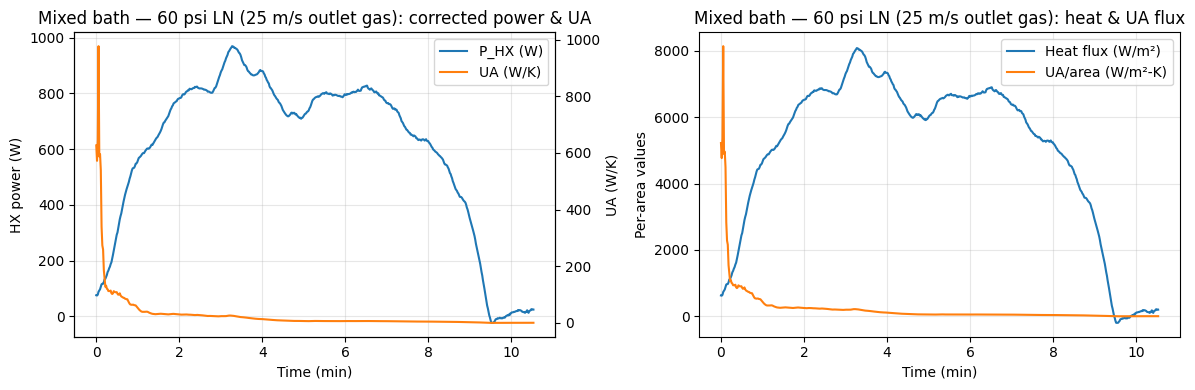

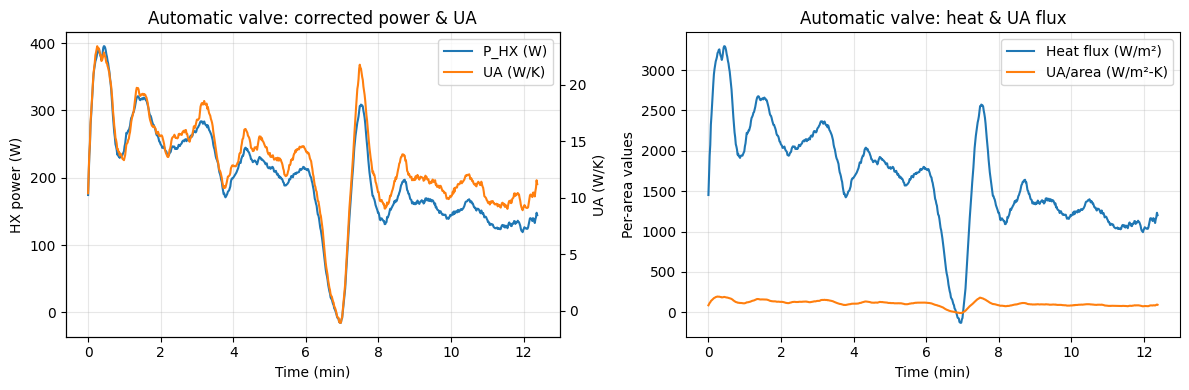

In [53]:
from IPython.display import display

for key, meta in DATASETS.items():
    fig, *_ = plot_power_and_flux(datasets[key], title_prefix=meta['title'])


## Key metrics & exports

The tables and figures below simply aggregate the previously defined quantities over fixed windows and export them for reports. Median, percentile, and energy summaries are all derived from $P_{\text{HX}}$, $q''$, $UA$, and $\Delta T$ as introduced above, with the total HX energy obtained by integrating $P_{\text{HX}}$ over the specified interval.



In [54]:
summary_frames = []
for key, df in datasets.items():
    summary = summarize_windows(df, SUMMARY_WINDOWS)
    summary.insert(0, 'dataset', key)
    summary_frames.append(summary)
summary_df = pd.concat(summary_frames, ignore_index=True)
summary_df


,dataset,window_min,samples,P_HX_median_W,P_HX_p10_W,P_HX_p90_W,Heat_flux_median_W_m2,UA_median_W_per_K,UA_flux_median_W_per_m2K,DeltaT_median_C
0,nomix,2-6,239,220.006478,174.474384,254.547366,1833.387313,10.632833,88.606943,21.04250
1,nomix,6-10,239,238.383276,197.789942,252.628932,1986.527297,6.578065,54.817204,35.00500
2,nomix,10-14,238,190.654827,157.137497,247.454752,1588.790225,2.460708,20.505903,77.48000
3,mixed,2-6,239,187.715640,109.645536,249.379077,1564.297003,103.871056,865.592136,1.55250
4,mixed,6-10,238,307.530179,259.782948,337.048098,2562.751493,108.621750,905.181250,2.80375
5,mixed,10-14,239,341.531082,326.249189,364.163416,2846.092349,78.784730,656.539418,4.30500
6,mixed_60psi,2-6,228,804.408336,727.667151,914.973543,6703.402801,12.399181,103.326512,69.72125
7,mixed_60psi,6-10,237,629.078060,1.429686,808.344519,5242.317167,4.443426,37.028551,139.90250
8,mixed_60psi,10-14,32,18.024784,13.900734,23.146492,150.206531,0.134808,1.123402,127.84750
9,auto,2-6,239,225.785181,193.777530,268.668583,1881.543174,14.471135,120.592788,15.62000


In [55]:
energy_rows = []
for key, df in datasets.items():
    t1 = min(ENERGY_WINDOW[1], float(df['t_min'].max()))
    energy_kJ = integrate_corrected_power(df, ENERGY_WINDOW[0], t1)
    energy_rows.append({'dataset': key, 'window_min': f"{ENERGY_WINDOW[0]}-{t1:.1f}", 'E_HX_kJ': energy_kJ})
energy_df = pd.DataFrame(energy_rows)
energy_df


,dataset,window_min,E_HX_kJ
0,nomix,2.0-12.0,135.538683
1,mixed,2.0-12.0,154.544433
2,mixed_60psi,2.0-10.5,321.490370
3,auto,2.0-12.0,107.900305


In [56]:
print(f"Ambient heat leak: {fit_result.heat_leak_W:.2f} W (95% CI {fit_result.ci95_low_W:.2f}-{fit_result.ci95_high_W:.2f} W)")
for key in DATASETS:
    flux = summary_df[(summary_df['dataset'] == key) & (summary_df['window_min'] == '6-10')]['Heat_flux_median_W_m2']
    flux_val = flux.iloc[0] if not flux.empty else float('nan')
    energy_val = energy_df.loc[energy_df['dataset'] == key, 'E_HX_kJ'].iloc[0]
    window_label = energy_df.loc[energy_df['dataset'] == key, 'window_min'].iloc[0]
    print(f"{key} median heat flux 6-10 min: {flux_val:.0f} W/m²")
    print(f"{key} integrated HX energy {window_label} min: {energy_val:.1f} kJ")


Ambient heat leak: 15.58 W (95% CI 15.56-15.61 W)
nomix median heat flux 6-10 min: 1987 W/m²
nomix integrated HX energy 2.0-12.0 min: 135.5 kJ
mixed median heat flux 6-10 min: 2563 W/m²
mixed integrated HX energy 2.0-12.0 min: 154.5 kJ
mixed_60psi median heat flux 6-10 min: 5242 W/m²
mixed_60psi integrated HX energy 2.0-10.5 min: 321.5 kJ
auto median heat flux 6-10 min: 1348 W/m²
auto integrated HX energy 2.0-12.0 min: 107.9 kJ


In [57]:
summary_out = REPORTS_DIR / 'hx_summary_windows_combined.csv'
energy_out = REPORTS_DIR / 'hx_energy_combined.csv'
leak_out = REPORTS_DIR / 'hx_heat_leak_20251023.txt'
summary_df.to_csv(summary_out, index=False)
energy_df.to_csv(energy_out, index=False)
with leak_out.open('w') as fh:
    fh.write(f"Ambient heat leak (t ≥ {WARMUP_TMIN_MIN} min): {fit_result.heat_leak_W:.4f} W\n")
    fh.write(f"1σ uncertainty: {fit_result.heat_leak_sigma_W:.4f} W\n")
    fh.write(f"95% CI: {fit_result.ci95_low_W:.4f} – {fit_result.ci95_high_W:.4f} W\n")
print('Saved:', summary_out)
print('Saved:', energy_out)
print('Saved:', leak_out)
for key, df in datasets.items():
    timeseries_out = PROCESSED_DIR / f'hx_timeseries_20251023_{key}.csv'
    keep = [
        'dataset',
        'time_s',
        'time_s_raw',
        't_min',
        'T_bulk_mean_C',
        'T_coil_mean_C',
        'DeltaT_C',
        'P_bath_W',
        'P_HX_W',
        'P_HX_W_m2',
        'UA_corr_W_per_K',
        'UA_per_area_W_per_m2K',
        'valve_state',
    ]
    cols = [c for c in keep if c in df.columns]
    df.loc[:, cols].to_csv(timeseries_out, index=False)
    print('Saved:', timeseries_out)

Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_summary_windows_combined.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_energy_combined.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_heat_leak_20251023.txt
Saved: /home/pocar-lab/Documents/HFE_System/data/processed/hx_timeseries_20251023_nomix.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/processed/hx_timeseries_20251023_mixed.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/processed/hx_timeseries_20251023_mixed_60psi.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/processed/hx_timeseries_20251023_auto.csv


### Windowed temperature fits

We fit the bath bulk-temperature evolution within each requested time span using a simple least-squares line. The slope translates to corrected HX power via $P_{\mathrm{HX}} = -C_p\,dT/dt + \dot{Q}_{\mathrm{amb}}$, from which we derive window-averaged UA, surface heat flux, and UA-per-area. The figures show the bulk mean temperatures with the fitted line for:
- No-mix: 2–12 min
- Mixed 25 psi: 5–20 min
- Mixed 60 psi: 2–8 min
- Automatic valve: 2–12 min

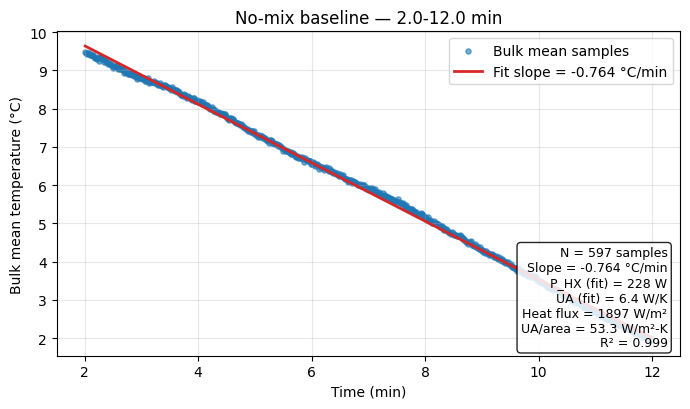

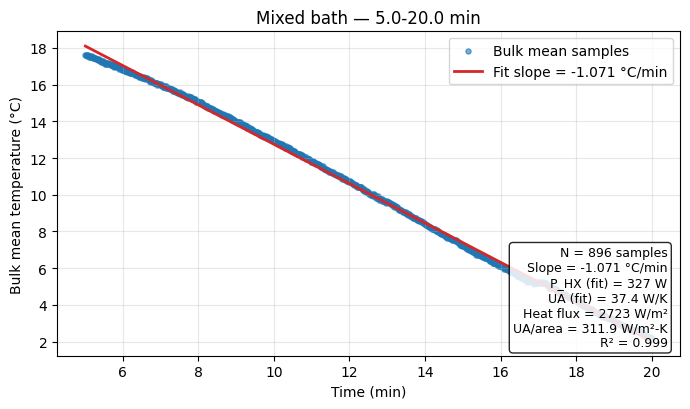

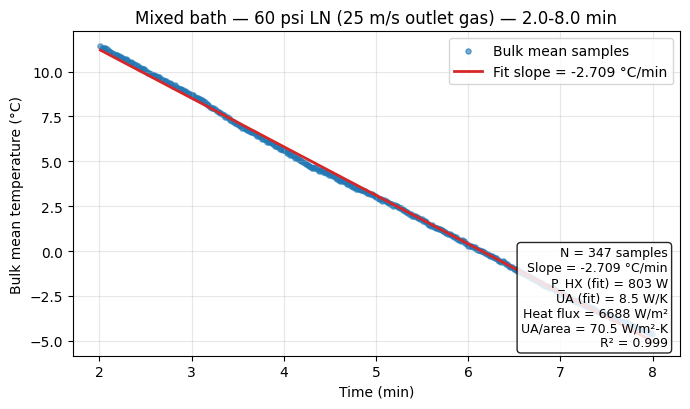

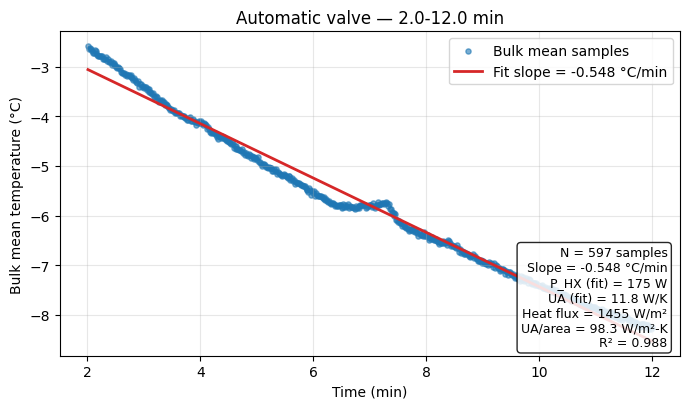

,dataset,title,window_min,samples,slope_C_per_min,slope_C_per_min_sigma,P_HX_fit_W,P_HX_fit_W_sigma,UA_fit_W_per_K,UA_fit_W_per_K_sigma,heat_flux_fit_W_m2,heat_flux_fit_W_m2_sigma,UA_area_fit_W_per_m2K,UA_area_fit_W_per_m2K_sigma,DeltaT_mean_C,r_squared
0,nomix,No-mix baseline,2.0-12.0,597,-0.764,0.001,227.7,0.3,6.40,0.01,1897.5,2.6,53.35,0.07,35.57,0.999
1,mixed,Mixed bath,5.0-20.0,896,-1.071,0.001,326.8,0.4,37.43,0.04,2723.4,3.0,311.93,0.34,8.73,0.999
2,mixed_60psi,Mixed bath — 60 psi LN (25 m/s outlet gas),2.0-8.0,347,-2.709,0.005,802.5,1.4,8.46,0.01,6687.8,11.8,70.53,0.12,94.82,0.999
3,auto,Automatic valve,2.0-12.0,597,-0.548,0.003,174.7,0.7,11.80,0.05,1455.5,6.1,98.31,0.41,14.80,0.988


In [58]:
from IPython.display import display

FIT_WINDOWS_REQUESTED = {
    'nomix': (2.0, 12.0),
    'mixed': (5.0, 20.0),
    'mixed_60psi': (2.0, 8.0),
    'auto': (2.0, 12.0),
}

fit_records = []
for key, window in FIT_WINDOWS_REQUESTED.items():
    df = datasets.get(key)
    meta = DATASETS.get(key, {})
    cp_for_dataset = meta.get('Cp_JK', Cp_JK)
    if df is None:
        print(f"Dataset {key} not loaded; skipping window {window[0]}-{window[1]} min.")
        continue
    try:
        fit = fit_temperature_window(
            df,
            Cp_JK=cp_for_dataset,
            heat_leak_W=HEAT_LEAK_W,
            hx_area_m2=HX_AREA_M2,
            t_window_min=window,
            dataset=key,
        )
    except ValueError as exc:
        print(f"{meta.get('title', key)} window {window[0]}-{window[1]} min: {exc}")
        continue

    title = f"{meta.get('title', key)} — {window[0]}-{window[1]} min"
    fig = plot_temperature_window_fit(fit, title=title)
    display(fig)
    plt.close(fig)

    slope_sigma = getattr(fit, 'slope_sigma_C_per_min', float('nan'))
    PHX_sigma = getattr(fit, 'P_HX_sigma_W', float('nan'))
    UA_sigma = getattr(fit, 'UA_sigma_W_per_K', float('nan'))
    heat_flux_sigma = getattr(fit, 'heat_flux_sigma_W_m2', float('nan'))
    UA_area_sigma = getattr(fit, 'UA_area_sigma_W_per_m2K', float('nan'))

    fit_records.append(
        {
            'dataset': key,
            'title': meta.get('title', key),
            'window_min': f"{window[0]}-{window[1]}",
            'samples': fit.samples,
            'slope_C_per_min': fit.slope_C_per_min,
            'slope_C_per_min_sigma': slope_sigma,
            'P_HX_fit_W': fit.P_HX_fit_W,
            'P_HX_fit_W_sigma': PHX_sigma,
            'UA_fit_W_per_K': fit.UA_fit_W_per_K,
            'UA_fit_W_per_K_sigma': UA_sigma,
            'heat_flux_fit_W_m2': fit.heat_flux_fit_W_m2,
            'heat_flux_fit_W_m2_sigma': heat_flux_sigma,
            'UA_area_fit_W_per_m2K': fit.UA_area_fit_W_per_m2K,
            'UA_area_fit_W_per_m2K_sigma': UA_area_sigma,
            'DeltaT_mean_C': fit.DeltaT_mean_C,
            'r_squared': fit.r_squared,
        }
    )

fit_df = pd.DataFrame(fit_records)
if not fit_df.empty:
    display(
        fit_df[
            [
                'dataset',
                'title',
                'window_min',
                'samples',
                'slope_C_per_min',
                'slope_C_per_min_sigma',
                'P_HX_fit_W',
                'P_HX_fit_W_sigma',
                'UA_fit_W_per_K',
                'UA_fit_W_per_K_sigma',
                'heat_flux_fit_W_m2',
                'heat_flux_fit_W_m2_sigma',
                'UA_area_fit_W_per_m2K',
                'UA_area_fit_W_per_m2K_sigma',
                'DeltaT_mean_C',
                'r_squared',
            ]
        ].round(
            {
                'slope_C_per_min': 3,
                'slope_C_per_min_sigma': 3,
                'P_HX_fit_W': 1,
                'P_HX_fit_W_sigma': 1,
                'UA_fit_W_per_K': 2,
                'UA_fit_W_per_K_sigma': 2,
                'heat_flux_fit_W_m2': 1,
                'heat_flux_fit_W_m2_sigma': 1,
                'UA_area_fit_W_per_m2K': 2,
                'UA_area_fit_W_per_m2K_sigma': 2,
                'DeltaT_mean_C': 2,
                'r_squared': 3,
            }
        )
    )
else:
    print('No window temperature fits to display.')


In [59]:
full_summary_out = REPORTS_DIR / 'hx_full_summary_windows.csv'
fit_df.to_csv(full_summary_out, index=False)

print('Saved:', full_summary_out)

Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_full_summary_windows.csv
